## Script to calculate urban fraction (sfturf) and impervious fraction (sftimf) for RegCM and REMO following: 

https://github.com/FPS-URB-RCC/CORDEX-CORE-WG/issues/21

In [1]:
import xarray as xr
import os
import glob
import sys
import numpy as np
import matplotlib.pyplot as plt
import uuid
from datetime import datetime
import pytz

In [2]:
RCM_DICT = {
    'EUR-11': 
    { 
        'REMO': 'GERICS_REMO2015',
        'RegCM': 'ICTP_RegCM4-6',
    },
    'EUR-22': 
    {
        'REMO': 'GERICS_REMO2015',
    },
    'WAS-22': {
        'REMO': 'GERICS_REMO2015',
        'RegCM': 'ICTP_RegCM4-7',
    },
    'EAS-22':
     {
        'REMO': 'GERICS_REMO2015',
        'RegCM': 'ICTP_RegCM4-4', ## There are no files for evaluation (urban fraction available)
    },
    'CAM-22':
     {
        'REMO': 'GERICS_REMO2015',
        'RegCM': 'ICTP_RegCM4-7',
    },
    'SAM-22':
     {
        'REMO': 'GERICS_REMO2015',
        'RegCM': 'ICTP_RegCM4-7',
    },
    'NAM-22':
     {
        'REMO': 'GERICS_REMO2015',
        'RegCM': 'ICTP_RegCM4-7',
    },
    'AUS-22':
     {
        'REMO': 'GERICS_REMO2015',
        'RegCM': 'ICTP_RegCM4-7',
    },
    'AFR-22':
     {
        'REMO': 'GERICS_REMO2015',
        'RegCM': 'ICTP_RegCM4-7',
    },
    'SEA-22':
    {
        'REMO': 'GERICS_REMO2015',
        'RegCM': 'ICTP_RegCM4-7',
    },
}

In [3]:
dic_sftimf = {"frequency": "fx",
          "standard_name": "area_fraction",
          "units": "%",
          "cell_methods": "area: mean where impervious",
          "cell_measures": "area: areacella",
          "long_name": "Percentage of the Grid Cell Occupied by impervious surface areas",
          "comment": "not in CMIP or in CF",
          "dimensions": "y x",
          "out_name": "sftimf",
          "type": "real"
         }

dic_sfturf = {"frequency": "fx",
          "standard_name": "area_fraction",
          "units": "%",
          "cell_methods": "area: mean where urban",
          "cell_measures": "area: areacella",
          "long_name": "Percentage of the Grid Cell Occupied by Urban Area	",
          "comment": "not in CMIP or in CF",
          "dimensions": "y x",
          "out_name": "sfturf",
          "type": "real"
         }

# Combine into a nested dictionary
combined_dict = {
    "sftimf": dic_sftimf,
    "sfturf": dic_sfturf
}

In [4]:
attrs_delete = ["driving_experiment", "driving_model_id", "driving_model_ensemble_member",
                "driving_experiment_name", "experiment", "ipcc_scenario_code", "experiment_id"]

In [5]:
regcm_domains = {'CORDEX_DOMAIN_Africa_CLM45_surface_2d.nc' : 'AFR-22.nc',
                 'CORDEX_DOMAIN_Australasia_CLM45_surface_2d.nc' : 'AUS-22.nc',
                 'CORDEX_DOMAIN_CentralAmerica_CLM45_surface_2d.nc': 'CAM-22.nc',
                 'CORDEX_DOMAIN_EastAsia_CLM45_surface_2d.nc' : 'EAS-22.nc',
                 'CORDEX_DOMAIN_Europe_CLM45_surface_2d_RegCM-4.6.nc' :  'EUR-11.nc',
                 'CORDEX_DOMAIN_NorthAmerica_CLM45_surface_2d.nc' : 'NAM-22.nc',
                 'CORDEX_DOMAIN_SouthAmerica_CLM45_surface_2d.nc' : 'SAM-22.nc',
                 'CORDEX_DOMAIN_SouthAsia_CLM45_surface_2d.nc' : 'WAS-22.nc',
                 'CORDEX_DOMAIN_SouthEastAsia_CLM45_surface_2d.nc': 'SEA-22.nc'}

In [6]:
def traverseDir(root):
    for (dirpath, dirnames, filenames) in os.walk(root):
        for file in filenames:
            if file.endswith(('.nc')):
                yield os.path.join(dirpath, file)

In [7]:
def load_static_variables(domain, model, root_esgf, root_nextcloud):
    """
    Load static variable data files for a specific domain and model from given root directories.

    Parameters:
    domain (str): The domain of the data (e.g., 'Europe').
    model (str): The model identifier (e.g., 'modelA').
    root_esgf (str): The root directory for ESGF data.
    root_nextcloud (str): The root directory for Nextcloud data.

    Returns:
    tuple: A tuple containing datasets for sftuf, orog, and sftlf.
    """
    
    if domain in ["NAM-22"]: #nextcloud
        file_orog = glob.glob(f"{root_nextcloud}{model}/orography/orog_{domain}*.nc")

    elif domain in ["EAS-22"] and model in ['RegCM']: #nextcloud
        #file_orog = glob.glob(f"{root_nextcloud}{model}/orography/orog_{domain}*.nc")
        file_orog = glob.glob(
            f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/MOHC-HadGEM2-ES/historical/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
        )
        
    else: #esgf
        
        file_orog = glob.glob(
            f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/fx/orog/*/orog_*.nc" 
        )

    orog = xr.open_dataset(file_orog[0])
    
    return orog, file_orog[0]

In [8]:
def urban_fixes(ds_urban, ds_orog, rcm, domain):
    
    if "time" in ds_urban.dims: 
        ds_urban = ds_urban.isel(time = 0)
        
    #if rcm == 'REMO' and domain == 'EUR-11':
    #    ds_urban = fix_360_longitudes(ds_urban, lonname = 'lon')
    #    # longitud and latitud for ds_sftuf does not match with orog/sftlf
    #    ds_urban['lon'][:] = ds_orog['lon']
    #    ds_urban['lat'][:] = ds_orog['lat']

    if rcm == 'RegCM':
        # If RegCM the are some extra rows and columns that we have to eliminate. Furthermore, native coordiantes are shiftes so we use lon and lat
        ds_urban = ds_urban.isel(jx = slice(1, -2), iy = slice(1, -2))
        ds_urban = ds_urban.assign_coords(jx=ds_orog.x, iy=ds_orog.y)
        #if domain == 'EAS-22':
        #    ds_urban = ds_urban.assign_coords(xlon=ds_orog.lon, xlat=ds_orog.lat)            

    return ds_urban

In [9]:
def calculate_urban_static_variables(ds, rcm, var):
    if (rcm == 'RegCM') and (var == 'sftimf'):
        ROAD_FRACTION = 1 - ds.WTLUNIT_ROOF
        IMPERVIOUS_ROAD_FRACTION = ROAD_FRACTION*(1 - ds.WTROAD_PERV)
        ISA = ds.WTLUNIT_ROOF + IMPERVIOUS_ROAD_FRACTION
        ds["sftimf"] = (ds.PCT_URBAN * ISA).sum(dim = 'numurbl')
    elif (rcm == 'RegCM') and (var == 'sfturf'):
        ds["sfturf"] = (ds.PCT_URBAN).sum(dim = 'numurbl')
    elif (rcm == 'REMO') and (var == 'sftimf'):
        ds["sftimf"] = ds['urban'] * 100
    elif (rcm == 'REMO') and (var == 'sfturf'):
        ds["sfturf"] = ds['urban'] * 100
    return ds

In [10]:
def create_dataset_regcm(ds, variable, dict_var):
    # Create the dataset
    ds_sftimf = xr.Dataset(
        {
            variable: (["y", "x"], ds[variable].values,
                      dict_var),
        },
        coords={
            "y": (["y"], ds.iy.values,
                   {
                       "standard_name": "projection_y_coordinate",
                       "long_name": "y-coordinate in Cartesian system",
                       "units": "km"
                   }),
            "x": (["x"], ds.jx.values,
                   {
                       "standard_name": "projection_x_coordinate",
                       "long_name": "x-coordinate in Cartesian system",
                       "units": "km"
                   }),
            "lat": (["y", "x"], ds.xlat.values,
                     {
                         "standard_name": "latitude",
                         "long_name": "Latitude at cross points",
                         "units": "degrees_north"
                     }),
            "lon": (["y", "x"], ds.xlon.values,
                     {
                         "standard_name": "longitude",
                         "long_name": "Longitude at cross points",
                         "units": "degrees_east"
                     })
        }
    )
    
    # Copy global attributes from the original dataset
    ds_sftimf.attrs = ds.attrs

    return ds_sftimf

In [11]:
def create_dataset_remo(ds, variable, dict_var):
    # Create the dataset
    ds_sftimf = xr.Dataset(
        {
            variable: (["rlat", "rlon"], ds[variable].values,
                      dict_var),
        },
        coords={
            "rlat": (["rlat"], ds.rlat.values,
                   {
                       "standard_name": "grid_latitude",
                       "long_name": "latitude in rotated pole grid",
                       "units": "degrees",
                       "axis": "Y"
                   }),
            "rlon": (["rlon"], ds.rlon.values,
                   {
                       "standard_name": "grid_longitude",
                       "long_name": "longitude in rotated pole grid",
                       "units": "degrees",
                       "axis": "X"
                   }),
            "lat": (["y", "x"], ds.xlat.values,
                     {
                         "standard_name": "latitude",
                         "long_name": "Latitude at cross points",
                         "units": "degrees_north"
                     }),
            "lon": (["y", "x"], ds.xlon.values,
                     {
                         "standard_name": "longitude",
                         "long_name": "Longitude at cross points",
                         "units": "degrees_east"
                     })
        }
    )
    
    # Copy global attributes from the original dataset
    ds_sftimf.attrs = ds.attrs

    return ds_sftimf

In [12]:
def fix_360_longitudes(
    dataset: xr.Dataset, lonname: str = "lon"
) -> xr.Dataset:
    """
    Fix longitude values.

    Function to transform datasets where longitudes are in (0, 360) to (-180, 180).

    Parameters
    ----------
    dataset (xarray.Dataset): data stored by dimensions
    lonname (str): name of the longitude dimension

    Returns
    -------
    dataset (xarray.Dataset): data with the new longitudes
    """
    lon = dataset[lonname]
    if lon.max().values > 180 and lon.min().values >= 0:
        dataset[lonname] = dataset[lonname].where(lon <= 180, other=lon - 360)
    return dataset

In [13]:
def check_coordinates(ds1, lat1, lon1, ds2, lat2, lon2):

    # Extract latitude and longitude values
    lats1 = ds1[lat1].values  
    lons1 = ds1[lon1].values 
    lats2 = ds2[lat2].values  
    lons2 = ds2[lon2].values
    
    # Check if the coordinates are the same
    lat_same = np.array_equal(lats1, lats2)
    lon_same = np.array_equal(lons1, lons2)
    
    # Print results
    if lat_same and lon_same:
        equal_c = True
    else:
        if not lat_same:
            print(f"{lat1} coordinates do not match.")
        if not lon_same:
            print(f"{lat2} coordinates do not match.")
        equal_c = False
    return equal_c

## Calculate urban static variables

In [14]:
root = "/lustre/gmeteo/WORK/ASNA/projects/fpsurbrcc/03_cordexcore_wg/"
dest = "/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/"
dest = "/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/new/"

In [15]:
root_esgf = '/lustre/gmeteo/DATA/ESGF/REPLICA/DATA/cordex/output/'
root_nextcloud = '/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/'

In [16]:
DATE_CREATED = str(datetime.now(pytz.timezone("Europe/Madrid")))

for rcm in ['RegCM', "REMO"]:
    for var in ['sftimf', 'sfturf']:
        path_save = f"{dest}{rcm}/{var}/"
        os.makedirs(path_save, exist_ok = True)
        
        files_dom = np.sort(list(traverseDir(f"{root}new_{rcm}_urban_fractions")))

        for f in files_dom:

            # Select domain from filename
            if rcm == 'RegCM':
                domain = regcm_domains[f.split('/')[-1]].split('.')[0]
            elif rcm == 'REMO':
                domain = f.split('/')[-1].split('_')[0]                

            # select model
            model = RCM_DICT[domain][rcm]

            # load orog and sftlf
            ds_orog, orog_file = load_static_variables(
                domain, rcm, root_esgf, root_nextcloud)

            if domain == 'EAS-22' and rcm == 'RegCM':# No evaluation files available in ESGF for EAS-22
                print("No evaluation files available on the ESGF for EAS-22 and for RegCM")
                continue
            if domain == 'NAM-22' and rcm == 'RegCM':# No evaluation files available in ESGF for NAM-22. Files downloaded by Chus in the nextcloud have differnete dimesnions
                print("No simulations available for NAM-22 and for RegCM.")
                continue

            # select enesmble mebber 
            ensemble_member = orog_file.split('/')[-7]

            # open urban static variable
            ds_u = xr.open_dataset(f)
            # apply urban fixes
            ds_u = urban_fixes(ds_u, ds_orog, rcm, domain)

            # validate coordinates

            GCM_model = ds_orog.attrs["driving_model_id"]
            experiment = ds_orog.attrs["driving_experiment_name"]
            member = ds_orog.attrs["driving_model_ensemble_member"]
            rcm_version = ds_orog.attrs["rcm_version_id"]
            filename = f"{var}_{domain}_{model}_{rcm_version}_fx.nc"

            if rcm == 'RegCM':
                equal_coods = check_coordinates(ds_u, 'xlat', 'xlon', ds_orog, 'lat', 'lon')
                if not equal_coods:
                    sys.exit()
                    print(f"Geographical coordinates do not match for {domain} and {model}")
                    continue

            elif rcm == 'REMO':
                equal_coods = check_coordinates(ds_u, 'rlat', 'rlon', ds_orog, 'rlat', 'rlon')
                if not equal_coods:
                    print(f"Native coordinates do not match for {domain} and {model}")
                    continue
                    
                equal_coods = check_coordinates(ds_u, 'lat', 'lon', ds_orog, 'lat', 'lon')
                if not equal_coods:
                    print(f"Geographical coordinates do not match for {domain} and {model}")
                    continue

            # calculate urban field
            ds_urb = calculate_urban_static_variables(ds_u, rcm, var)
            ds_orog['orog'][:] = ds_urb[var].values
            ds_orog['orog'].attrs.clear()
            ds_urb = ds_orog.rename_vars({'orog': var})
            ds_urb.attrs["frequency"] = 'fx'
            for dd in combined_dict[var]:
                ds_urb[var].attrs[dd] = combined_dict[var][dd]
            ds_urb.attrs["creation_date"] = DATE_CREATED
            ds_urb.attrs["tracking_id"] = str(uuid.uuid4())
            if rcm == 'REMO':
                ds_urb.attrs["comment"] = ds_urb.attrs["comment"] + " Urban fraction prepared by Joni-Pekka Pietikäinen: Joni-Pekka.Pietikaeinen@hereon.de"

            for attr_r in attrs_delete:
                if attr_r in ds_urb.attrs:
                    del ds_urb.attrs[attr_r]
            
            ds_urb.to_netcdf(f"{path_save}{filename}")

No evaluation files available on the ESGF for EAS-22 and for RegCM
No simulations available for NAM-22 and for RegCM.
No evaluation files available on the ESGF for EAS-22 and for RegCM
No simulations available for NAM-22 and for RegCM.


In [20]:
RCM_DICT = {
    'EAS-22':
     {
        'RegCM': 'KNU_RegCM4-0',  ## Only evaluation scenario (## Urban fraction is 0). No available OROG in ESFG
     },
    'NAM-22':
    {
        'RegCM': 'ISU_RegCM4_v4-4-rc8', ## Urban fraction is 0
    },
}

In [21]:
def load_static_variables(domain, model, root_esgf, root_nextcloud):
    """
    Load static variable data files for a specific domain and model from given root directories.

    Parameters:
    domain (str): The domain of the data (e.g., 'Europe').
    model (str): The model identifier (e.g., 'modelA').
    root_esgf (str): The root directory for ESGF data.
    root_nextcloud (str): The root directory for Nextcloud data.

    Returns:
    tuple: A tuple containing datasets for sftuf, orog, and sftlf.
    """
    
    if domain in ["NAM-22"]: #nextcloud
        file_orog = glob.glob(f"{root_nextcloud}{model}/orography/orog_{domain}*.nc")

    elif domain in ["EAS-22"] and model in ['RegCM']: #nextcloud
        #file_orog = glob.glob(f"{root_nextcloud}{model}/orography/orog_{domain}*.nc")
        file_orog = glob.glob(
            f"{root_esgf}{domain}/{RCM_DICT[domain][model].split('_')[0]}/ECMWF-ERAINT/evaluation/*/{RCM_DICT[domain][model].split('_')[1]}/*/day/tasmin/*/tasmin_*.nc" 
        )
        
    orog = xr.open_dataset(file_orog[0])
    
    return orog, file_orog[0]

In [35]:
DATE_CREATED = str(datetime.now(pytz.timezone("Europe/Madrid")))

for domain in RCM_DICT.keys():
    for rcm in RCM_DICT[domain]:
        for var in ['sftimf', 'sfturf']:
            path_save = f"{dest}{rcm}/{var}/"
            os.makedirs(path_save, exist_ok = True)
                      
            # select model
            model = RCM_DICT[domain][rcm]
    
            # load orog and sftlf
            ds_orog, orog_file = load_static_variables(
                domain, rcm, root_esgf, root_nextcloud)
    
            # select enesmble mebber 
            ensemble_member = orog_file.split('/')[-7]
    
            # open urban static variable
            #ds_u = xr.open_dataset(f)
            # apply urban fixes
            #ds_u = urban_fixes(ds_u, ds_orog, rcm, domain)
    
                # validate coordinates
    
            GCM_model = ds_orog.attrs["driving_model_id"]
            experiment = ds_orog.attrs["driving_experiment_name"]
            member = ds_orog.attrs["driving_model_ensemble_member"]
            if domain == 'EAS-22':
                rcm_version = ds_orog.attrs["RCM_version_id"]
            else:
                rcm_version = ds_orog.attrs["rcm_version_id"]
            if domain == 'NAM-22':
                filename = f"{var}_{domain}_{model}_fx.nc"
            else:
                filename = f"{var}_{domain}_{model}_{rcm_version}_fx.nc"
    
            if domain == 'EAS-22':
                # calculate urban field
                ds_orog = ds_orog.drop_dims('time')
                ds_urb = ds_orog.copy()
                ds_urb[var] = (["lat", "lon"], np.zeros((len(ds_orog["y"]), len(ds_orog["x"]))))
            else:
                # calculate urban field
                ds_orog['orog'][:] = 0
                ds_orog['orog'].attrs.clear()
                ds_urb = ds_orog.rename_vars({'orog': var})
            ds_urb.attrs["frequency"] = 'fx'
            for dd in combined_dict[var]:
                ds_urb[var].attrs[dd] = combined_dict[var][dd]
            ds_urb.attrs["creation_date"] = DATE_CREATED
            ds_urb.attrs["tracking_id"] = str(uuid.uuid4())

            for attr_r in attrs_delete:
                if attr_r in ds_urb.attrs:
                    del ds_urb.attrs[attr_r]
            
            ds_urb.to_netcdf(f"{path_save}{filename}",  unlimited_dims=[])

## Compare files

In [26]:
def crop_area(ds, lat_city, lon_city, range_size, 
              y, x, lat, lon):
    
    iy = ds[y]; jx = ds[x]
    xlat = ds[lat]; xlon = ds[lon]

    # Step 1: Find the closest indices
    # Flatten the latitude and longitude arrays
    flat_lat = xlat.values.flatten()
    flat_lon = xlon.values.flatten()
    
    # Compute the distances
    distances = np.sqrt((flat_lat - lat_city)**2 + (flat_lon - lon_city)**2)
    
    # Find the index of the minimum distance
    min_index = np.argmin(distances)
    
    # Get the 2D index from the 1D index
    iy_index, jx_index = np.unravel_index(min_index, xlat.shape)
    
    # Step 2: Define a range around this point
    # Define a range (example: 10 points in each direction)
    range_size = 10
    
    iy_start = max(iy_index - range_size, 0)
    iy_end = min(iy_index + range_size, len(iy) - 1)
    
    jx_start = max(jx_index - range_size, 0)
    jx_end = min(jx_index + range_size, len(jx) - 1)
    
    # Step 3: Select the area
    subset = ds.isel({y:slice(iy_start, iy_end), x:slice(jx_start, jx_end)})

    return subset

In [17]:
# Paris
lat_city = 48.864716
lon_city = 2.349014
# Berlin
lat_city = 52.520008
lon_city = 13.404954
# Athens
lat_city = 37.983810
lon_city = 23.727539

## RegCM

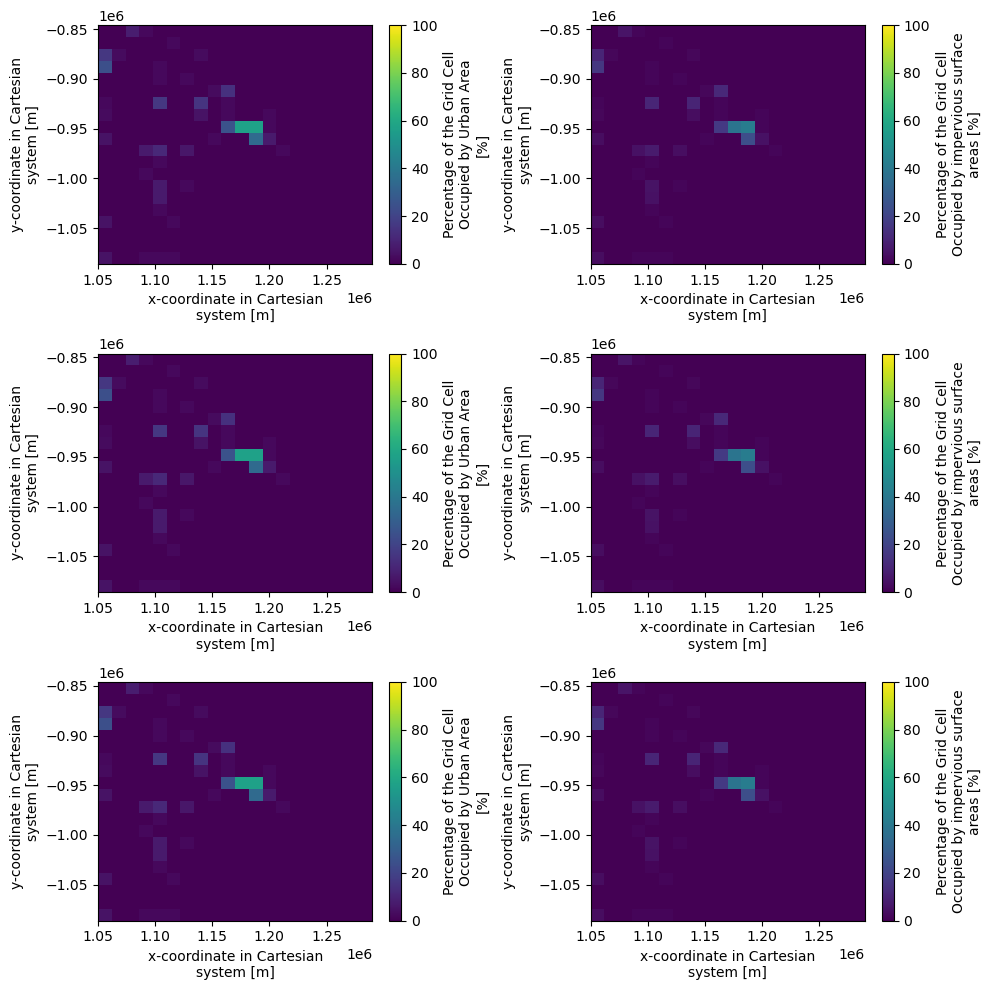

In [18]:
## sfturf
ds_sfturf = xr.open_dataset(f"{dest}RegCM/sfturf/sfturf_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_ICTP_RegCM4-6_fx.nc")
ds_sfturf_crop = crop_area(ds_sfturf, lat_city, lon_city, 10, 'y', 'x', 'lat', 'lon')
## new 
ds_sftimf = xr.open_dataset(f"{dest}RegCM/sftimf/sftimf_EUR-11_ECMWF-ERAINT_evaluation_r1i1p1_ICTP_RegCM4-6_fx.nc")
ds_sftimf_crop = crop_area(ds_sftimf, lat_city, lon_city, 10, 'y', 'x', 'lat', 'lon')

# Create a figure and a 2x3 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Loop through each subplot and add content
for i in range(3):
    for j in range(2):
        if j == 0:
            ds_sfturf_crop['sfturf'].plot(ax = axs[i, j], vmin = 0, vmax = 100)
        else:
            ds_sftimf_crop['sftimf'].plot(ax = axs[i, j], vmin = 0, vmax = 100)

# Adjust layout
plt.tight_layout()
plt.show()

#fig.savefig('urb_2d_old_vs_new.png', bbox_inches='tight')

## REMO

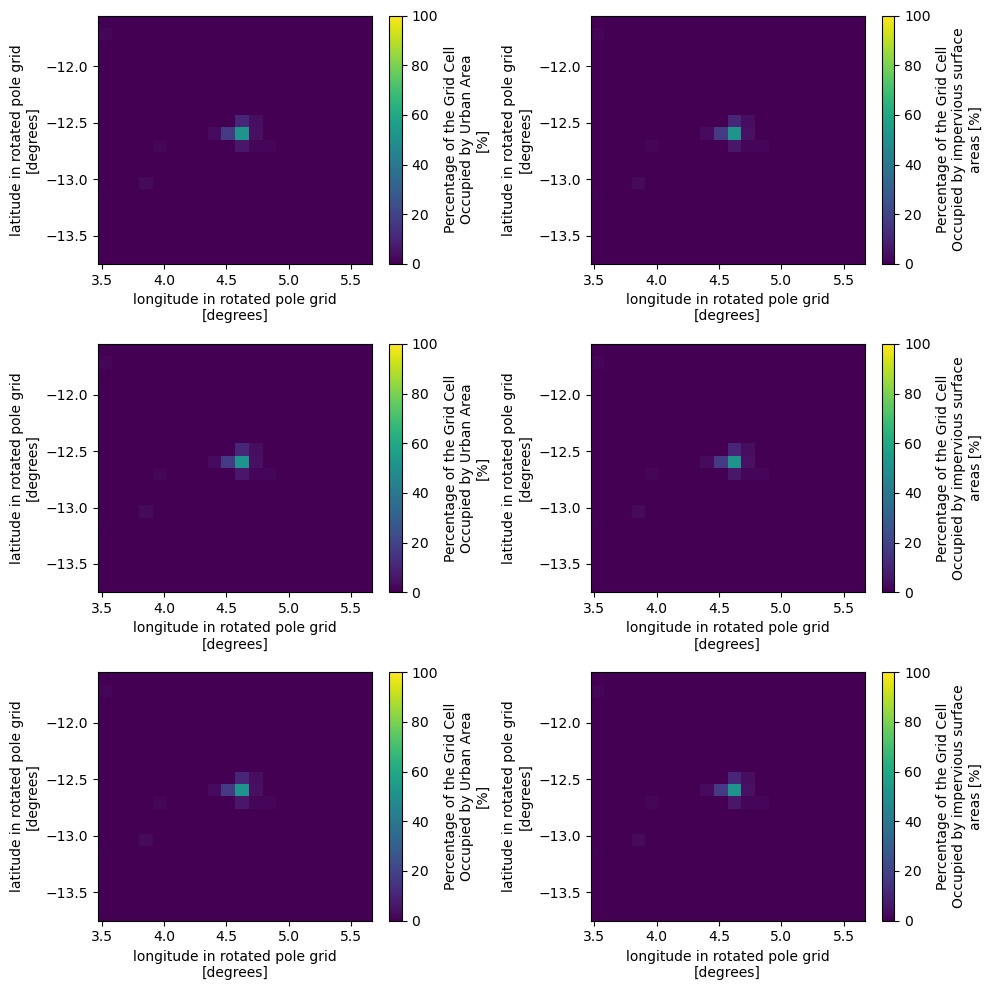

In [19]:
## sfturf
ds_sfturf = xr.open_dataset(f"{dest}REMO/sfturf/sfturf_EUR-11_ECMWF-ERAINT_evaluation_r0i0p0_GERICS_REMO2015_fx.nc")
ds_sfturf_crop = crop_area(ds_sfturf, lat_city, lon_city, 10, 'rlat', 'rlon', 'lat', 'lon')
## new 
ds_sftimf = xr.open_dataset(f"{dest}REMO/sftimf/sftimf_EUR-11_ECMWF-ERAINT_evaluation_r0i0p0_GERICS_REMO2015_fx.nc")
ds_sftimf_crop = crop_area(ds_sftimf, lat_city, lon_city, 10, 'rlat', 'rlon', 'lat', 'lon')

# Create a figure and a 2x3 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Loop through each subplot and add content
for i in range(3):
    for j in range(2):
        if j == 0:
            ds_sfturf_crop['sfturf'].plot(ax = axs[i, j], vmin = 0, vmax = 100)
        else:
            ds_sftimf_crop['sftimf'].plot(ax = axs[i, j], vmin = 0, vmax = 100)

# Adjust layout
plt.tight_layout()
plt.show()

#fig.savefig('urb_2d_old_vs_new.png', bbox_inches='tight')

In [19]:
root = "/lustre/gmeteo/WORK/DATA/CORDEX-FPS-URB-RCC/nextcloud/CORDEX-CORE-WG/new/"

In [28]:
# Sydney
lon_city = 151.01810
lat_city =  -33.79170
# Melbourne     
lon_city = 144.96
lat_city = -37.81

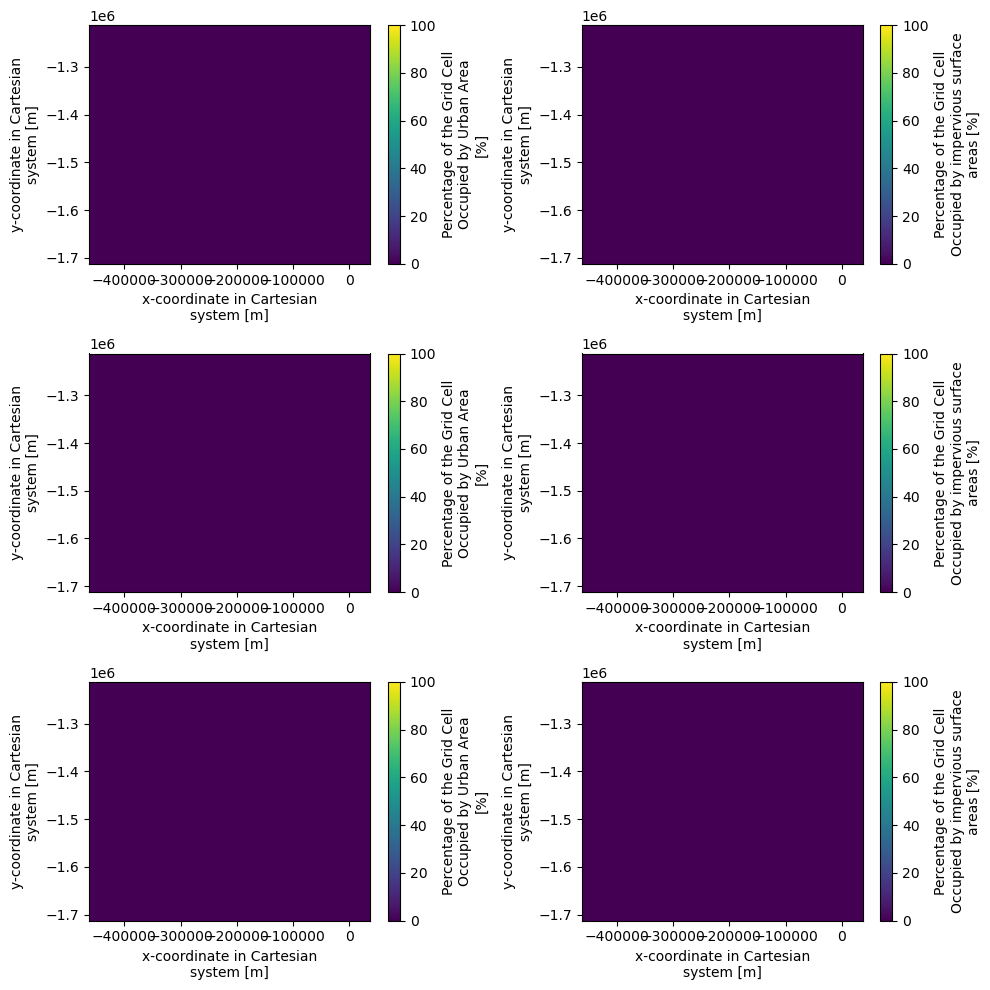

In [29]:
## sfturf
ds_sfturf = xr.open_dataset(f"{root}RegCM/sfturf/sfturf_AUS-22_ICTP_RegCM4-7_v0_fx.nc")
ds_sfturf_crop = crop_area(ds_sfturf, lat_city, lon_city, 10, 'y', 'x', 'lat', 'lon')
## new 
ds_sftimf = xr.open_dataset(f"{root}RegCM/sftimf/sftimf_AUS-22_ICTP_RegCM4-7_v0_fx.nc")
ds_sftimf_crop = crop_area(ds_sftimf, lat_city, lon_city, 10, 'y', 'x', 'lat', 'lon')

# Create a figure and a 2x3 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Loop through each subplot and add content
for i in range(3):
    for j in range(2):
        if j == 0:
            ds_sfturf_crop['sfturf'].plot(ax = axs[i, j], vmin = 0, vmax = 100)
        else:
            ds_sftimf_crop['sftimf'].plot(ax = axs[i, j], vmin = 0, vmax = 100)

# Adjust layout
plt.tight_layout()
plt.show()

In [33]:
ds_sftimf.lon.values[ds_sftimf['sftimf']>0]

array([106.66710663, 106.87921906, 106.51715851, 106.72891235,
       106.94076538, 107.0022049 ])

In [34]:
ds_sftimf.lat.values[ds_sftimf['sftimf']>0]

array([-6.45020485, -6.51153803, -6.17804909, -6.23957109, -6.30082703,
       -6.09029007])

In [2]:
root = '/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/CSAM-4i/USP/ECMWF-ERA5/evaluation/r1i1p1f1/USP-RegCM471/v1/fx/landuse/'
ds = xr.open_dataset(f"{root}landuse_CSAM-4i_ECMWF-ERA5_evaluation_r1i1p1f1_USP-RegCM471_v1_fx.nc")

In [25]:
ds['landuse_round'] = ds['landuse'].round(0)

In [42]:
lat_lim = slice(-34.559-1, -34.559 + 1)
lon_lim =  slice(-58.416-1, -58.416 + 1)

In [43]:
ds_buenos = ds.sel(lat=lat_lim, lon=lon_lim)

In [44]:
categories = np.sort(np.unique(ds['landuse_round'].values))
categories = categories[~np.isnan(categories)]

In [45]:
# Step 1: Create sample categorical data
categories = np.sort(np.unique(ds['landuse_round'].values))
categories = categories[~np.isnan(categories)]
category_names = [f"Class {cat}" for cat in categories]
data = np.random.choice(categories, size=(10, 10))  # Random categorical data

In [46]:
cmap = plt.get_cmap("tab20", len(categories))  # Easy way to pick a color palette

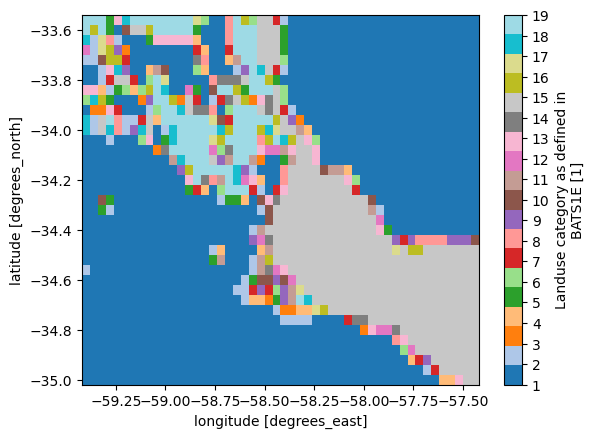

In [47]:
ds_buenos["landuse_round"].plot.imshow(cmap=cmap, add_labels=True, cbar_kwargs={"ticks": categories})

In [28]:
ds_buenos = ds.sel(lat=lat_lim, lon=lon_lim)

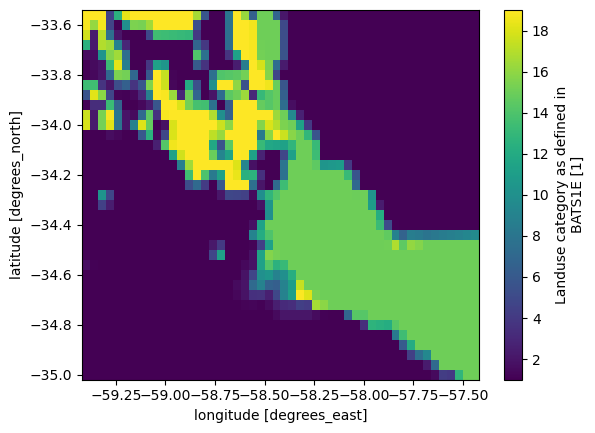

In [24]:
ds_buenos['landuse_round'].plot()

## Interpolate 

In [60]:
import c3s_atlas.software.interpolation as xesmfCICA

In [39]:
def traverseDir(root, end):
    for (dirpath, dirnames, filenames) in os.walk(root):
        for file in filenames:
            if file.endswith((end)):
                yield os.path.join(dirpath, file)

In [50]:
def select_domain(ds, lats_ref, lons_ref):
    lons_d = ds.lon.data
    lats_d = ds.lat.data
    if (lons_d>180).any():
        lons_d[lons_d>180] = lons_d[lons_d>180] -360
    lons_d_max = np.max(lons_d)
    lons_d_min = np.min(lons_d)
    lats_d_max = np.max(lats_d)
    lats_d_min = np.min(lats_d)

    lons_ref_cut = lons_ref[(lons_ref>lons_d_min) & (lons_ref<lons_d_max)]
    lats_ref_cut = lats_ref[(lats_ref>lats_d_min) & (lats_ref<lats_d_max)]

    return lats_ref_cut, lons_ref_cut

In [56]:
#Load reference grid
ds_ref_025 = xr.open_dataset('land_sea_mask_grd025.nc')
ds_ref_012 = xr.open_dataset('land_sea_mask_grd012p5.nc')

In [52]:
# Interpolate data
int_attr = {'interpolation_method' : None, 
            'lats' : None,
            'lons' : None,
            'var_name' : None
}

In [44]:
files = np.sort(list(traverseDir(dest, '.nc')))

In [ ]:
for file in files:

    int_attr['var_name'] = file.split('/')[-1].split('_')[0]

    domain = file.split('/')[-1].split('_')[1]
    
    if '-11' in domain:
        lats_ref = np.sort(ds_ref_012.lat.data)
        lons_ref = np.sort(ds_ref_012.lon.data)
    elif '-22' in domain:
        lats_ref = np.sort(ds_ref_025.lat.data)
        lons_ref = np.sort(ds_ref_025.lon.data)

    filepath_root = '/'.join(file.split('/')[:-1])
    filename_root = file.split('/')[-1]

    # open file
    ds = xr.open_dataset(file)
    # cut destination grid and update attr
    lats_ref, lons_ref = select_domain(ds, lats_ref, lons_ref)
    int_attr['lats'] = lats_ref
    int_attr['lons'] = lons_ref

    # Conservative
    int_attr['interpolation_method'] = 'conservative_normed'
    filepath_dest = filepath_root
    filename_dest = file.split('/')[-1].replace(domain, domain +'c')


    INTER = xesmfCICA.Interpolator(int_attr)
    ds_inter = INTER(ds)
    # save the results
    if not os.path.exists(filepath_dest):
        os.makedirs(filepath_dest)
    mask = np.isnan(ds_inter[int_attr['var_name']]) 
    ds_inter.to_netcdf(filepath_dest + '/' +  filename_dest)

    # NN
    int_attr['interpolation_method'] = 'nearest_s2d'
    filepath_dest = filepath_root
    filename_dest = file.split('/')[-1].replace(domain, domain +'n')

    INTER = xesmfCICA.Interpolator(int_attr)
    ds_inter = INTER(ds)
    # save the results
    if not os.path.exists(filepath_dest):
        os.makedirs(filepath_dest) 
    ds_inter[int_attr['var_name']] = ds_inter[int_attr['var_name']].where(~mask)
    ds_inter.to_netcdf(filepath_dest + '/' +  filename_dest)
    
    ds.close()